In [1]:
import gc
import os 
import torch
import pickle
import pandas as pd

import matplotlib.pyplot as plt

from collections import OrderedDict
from datetime import datetime

import utils.print as print_f

from utils.transforms import get_transform
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.save import  get_train_data
from utils.plot import transparent_cmap, plot_result, plot_loss, get_legend_elements
from data.dataset import ReflacxDataset, collate_fn
from models.rcnn import multimodal_maskrcnn_resnet50_fpn


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn'


%matplotlib inline

In [2]:
# Clean up memory.
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [3]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

In [4]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

This notebook will running on device: [cuda]


In [5]:
use_clinical = False

In [6]:
disease_cmap = {
    "transparent": {
        "Enlarged cardiac silhouette": transparent_cmap(plt.cm.autumn),
        "Atelectasis": transparent_cmap(plt.cm.Reds),
        "Pleural abnormality": transparent_cmap(plt.cm.Oranges),
        "Consolidation": transparent_cmap(plt.cm.Greens),
        "Pulmonary edema": transparent_cmap(plt.cm.Blues),
    },
    "solid": {
        "Enlarged cardiac silhouette": "yellow",
        "Atelectasis": "red",
        "Pleural abnormality": "orange",
        "Consolidation": "lightgreen",
        "Pulmonary edema": "dodgerblue",
    },
}

legend_elements = get_legend_elements(disease_cmap["solid"])

In [7]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": use_clinical,
    "using_full_reflacx": False,
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "using_full_reflacx": False,},
    transforms=get_transform(train=False),
)

train_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="train", transforms=get_transform(train=True),
)

val_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="val", transforms=get_transform(train=False),
)

test_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="test", transforms=get_transform(train=False),
)

batch_size = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)


In [8]:
train_dataset[0]

(tensor([[[0.5608, 0.5608, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
          [0.5569, 0.5647, 0.5647,  ..., 0.0000, 0.0000, 0.0000],
          [0.5490, 0.5569, 0.5608,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7686, 0.7686, 0.7647,  ..., 1.0000, 1.0000, 1.0000],
          [0.7608, 0.7647, 0.7608,  ..., 1.0000, 1.0000, 1.0000],
          [0.7529, 0.7569, 0.7569,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5608, 0.5608, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
          [0.5569, 0.5647, 0.5647,  ..., 0.0000, 0.0000, 0.0000],
          [0.5490, 0.5569, 0.5608,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7686, 0.7686, 0.7647,  ..., 1.0000, 1.0000, 1.0000],
          [0.7608, 0.7647, 0.7608,  ..., 1.0000, 1.0000, 1.0000],
          [0.7529, 0.7569, 0.7569,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5608, 0.5608, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
          [0.5569, 0.5647, 0.5647,  ..., 0.0000, 0.0000, 0.0000],
          [0.5490, 0.5569, 0.5608,  ...,

In [9]:
# Check max count.
# max([len(detect_eval_dataset[i][-1]['boxes']) for i in range(len(detect_eval_dataset))])

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        rpn_nms_thresh=0.3,
        box_detections_per_img=6,  # max bboxes count in dataset.
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model


def get_multimodal_model_instance_segmentation(
    num_classes,
    rpn_nms_thresh=0.3,
    box_detections_per_img=6,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
    pretrained_backbone=True,
    trainable_backbone_layers=None,
    clinical_input_channels=32,
    clinical_num_len=9,
    clinical_conv_channels=64,
    fuse_conv_channels=64,
    use_clinical=False,
):

    model = multimodal_maskrcnn_resnet50_fpn(
        pretrained=True,
        rpn_nms_thresh=rpn_nms_thresh,
        box_detections_per_img=box_detections_per_img,
        box_nms_thresh=box_nms_thresh,
        pretrained_backbone=pretrained_backbone,
        trainable_backbone_layers=trainable_backbone_layers,
        clinical_input_channels=clinical_input_channels,
        clinical_num_len=clinical_num_len,
        clinical_conv_channels=clinical_conv_channels,
        fuse_conv_channels=fuse_conv_channels,
        use_clinical=use_clinical,
        rpn_score_thresh=rpn_score_thresh,
        box_score_thresh=box_score_thresh,
    )

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model


In [11]:
import torchvision
from torchvision.models.detection import FasterRCNN

# trainable_backbone_layers = torchvision.models.detection.backbone_utils._validate_trainable_layers(
#     True, None, 5, 3
# )
# backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone(
#     "resnet50", pretrained=True, trainable_layers=trainable_backbone_layers
# )
# backbone.out_channels = 256


######################## For MobileNet backbone ########################
# from torchvision.models.detection.faster_rcnn import AnchorGenerator
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone.out_channels = 1280

# model = FasterRCNN(
#     backbone,
#     num_classes=len(train_dataset.labels_cols) + 1,
#     rpn_anchor_generator=None,
#     box_roi_pool=None,
# )

# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
# )
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=["0"], output_size=7, sampling_ratio=2
# )
########################################################################


# ResNet (Smaller model.)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#     pretrained_backbone=True, num_classes=len(train_dataset.labels_cols) + 1,
# )

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#     pretrained_backbone=True, num_classes=len(train_dataset.labels_cols) + 1,
# )

# testing with PennFudanDataset

# Trainable fasterrcnn
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#     # pretrained_backbone=True, num_classes=2,
#     pretrained=True,
#     # num_classes=2,
#     rpn_nms_thresh=0.5,
#     box_detections_per_img=10,
#     box_nms_thresh=0.2,
# )

# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# model = get_model_instance_segmentation(len(train_dataset.labels_cols) + 1)

# model = torchvision.models.detection.maskrcnn_resnet50_fpn(
#         pretrained=True,
#         # num_classes=len(train_dataset.labels_cols) +1,
#         rpn_nms_thresh=0.5,
#         box_detections_per_img=10,
#         box_nms_thresh=0.2,
#     )


model = get_model_instance_segmentation(len(train_dataset.labels_cols) +1)
# model = get_multimodal_model_instance_segmentation(
#     len(train_dataset.labels_cols) +1,
#     use_clinical=use_clinical,
# )
    
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")

Model size: 43,943,923


In [13]:
params = [p for p in model.parameters() if p.requires_grad]
lr_scheduler = None

# construct an optimizer

# optimizer = torch.optim.Adam(params, lr=0.05 ,weight_decay=0.0005)
# lr_scheduler = None

## Original Setting (Kinda work)
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=10,
                                                gamma=0.5)

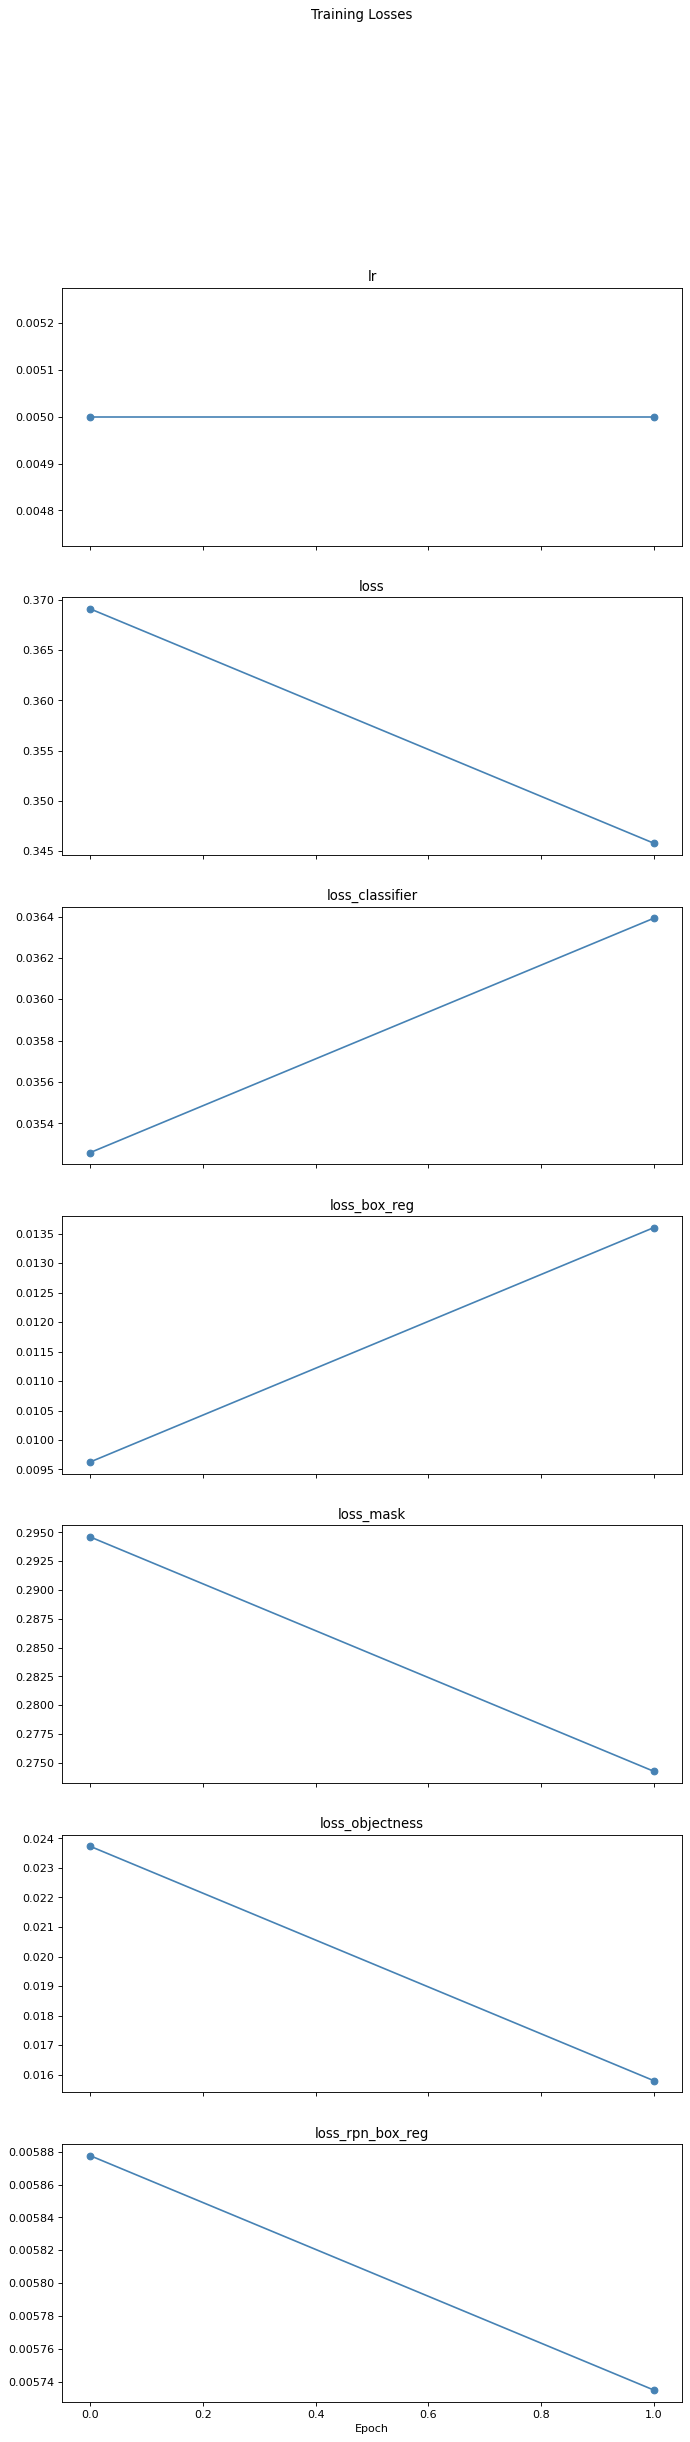

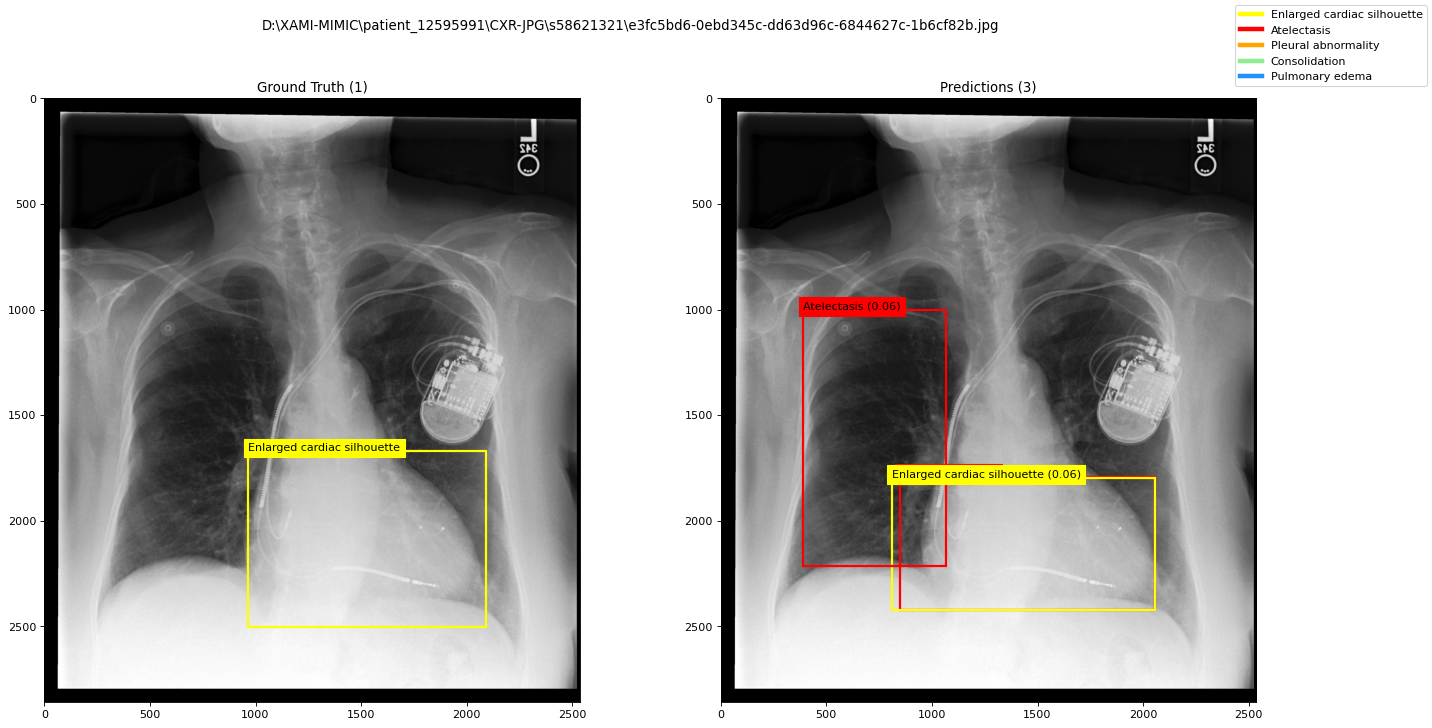

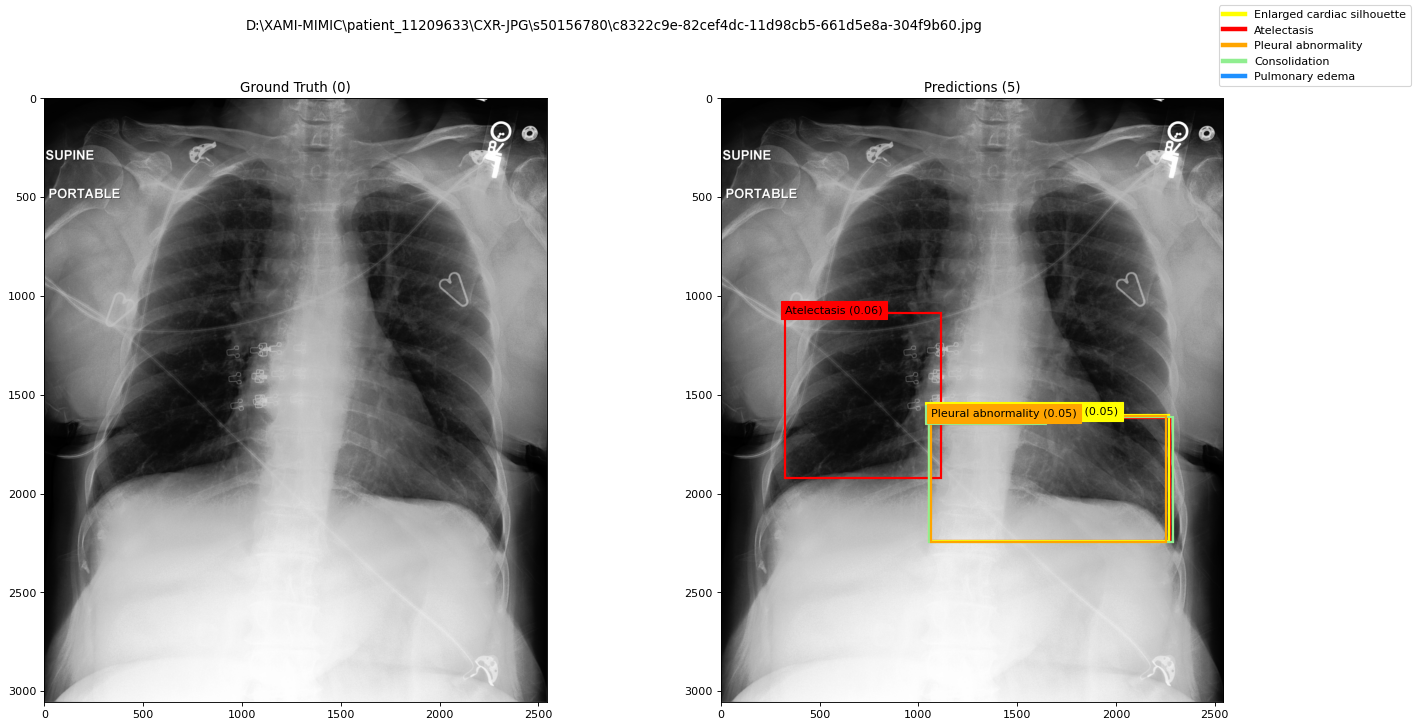

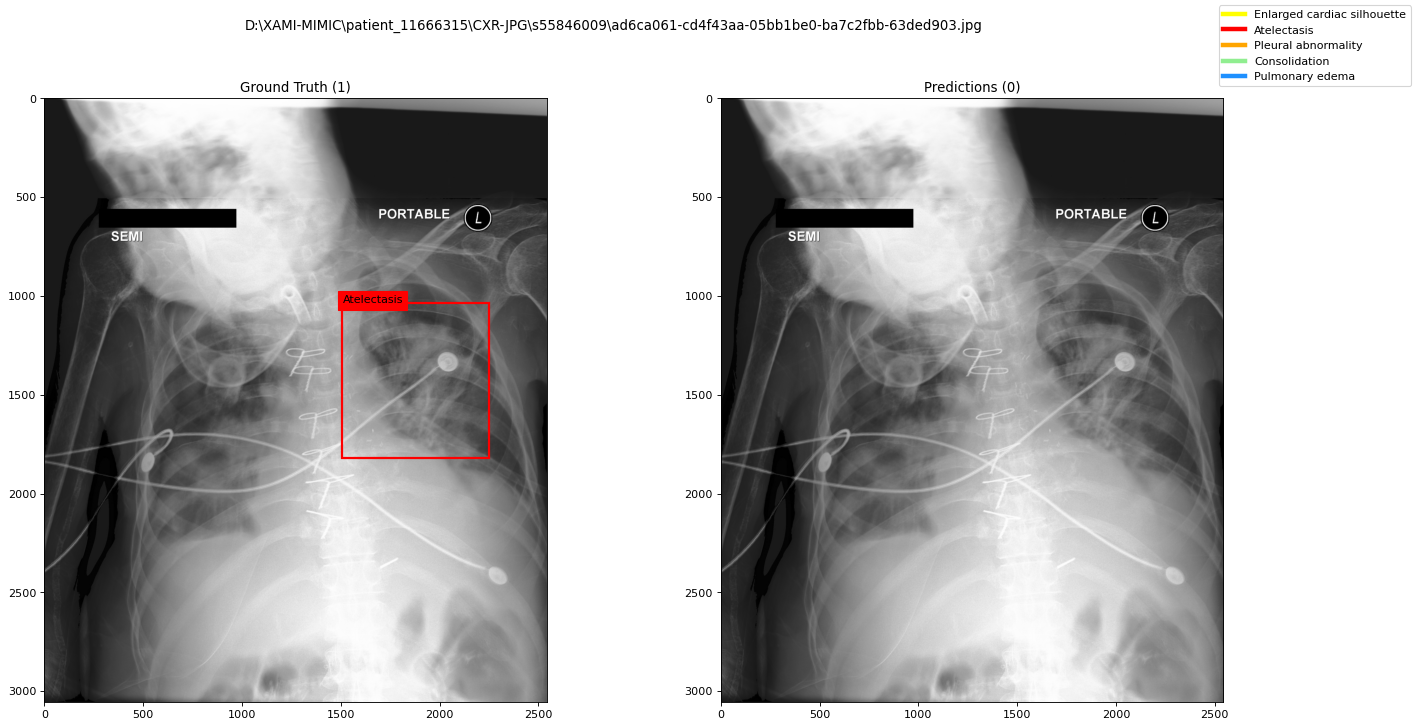

creating index...
index created!
Test:  [ 0/26]  eta: 0:00:36  model_time: 0.4341 (0.4341)  evaluator_time: 0.3891 (0.3891)  time: 1.3943  data: 0.5071  max mem: 5456


KeyboardInterrupt: 

In [14]:
num_epochs = 100

train_logers = []
val_evaluators = []

start_t = datetime.now()

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    model.train()

    train_loger = xami_train_one_epoch(
        model, optimizer, train_dataloader, device, epoch, print_freq=10
    )
    train_logers.append(train_loger)

    model.eval()

    plot_loss(train_logers)

    for i in [250, 99, 199]:
        plot_result(
            model=model,
            dataset=detect_eval_dataset,
            device=device,
            idx= i,
            legend_elements= legend_elements,
            disease_cmap =disease_cmap,
            seg=False,
            seg_thres=0.5,
        )

    # update the learning rate
    if not lr_scheduler is None:
        lr_scheduler.step()
    # evaluate on the test dataset
    val_evaluator = xami_evaluate(model, val_dataloader, device=device)
    val_evaluators.append(val_evaluator)

end_t = datetime.now()

sec_took = (end_t - start_t).seconds

print_f.print_title(
    f"| Training Done, start testing! | Training time: [{sec_took}] seconds, Avg time / Epoch: [{sec_took/num_epochs}] seconds"
)

test_evaluator = xami_evaluate(model, test_dataloader, device=device)


In [ ]:
# chekcing if a part of the model is being trained.
# for sector in [model.clinical_convs, model.fuse_convs]:
#     print(
#         sum(
#             [
#                 sum([p.grad.abs().sum() for p in model.clinical_convs[k].parameters()])
#                 for k in sector.keys()
#             ]
#         )
#     )

tensor(1.5677, device='cuda:0')
tensor(1.5677, device='cuda:0')


In [ ]:
test_evaluator.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
IoU metric: segm
 A

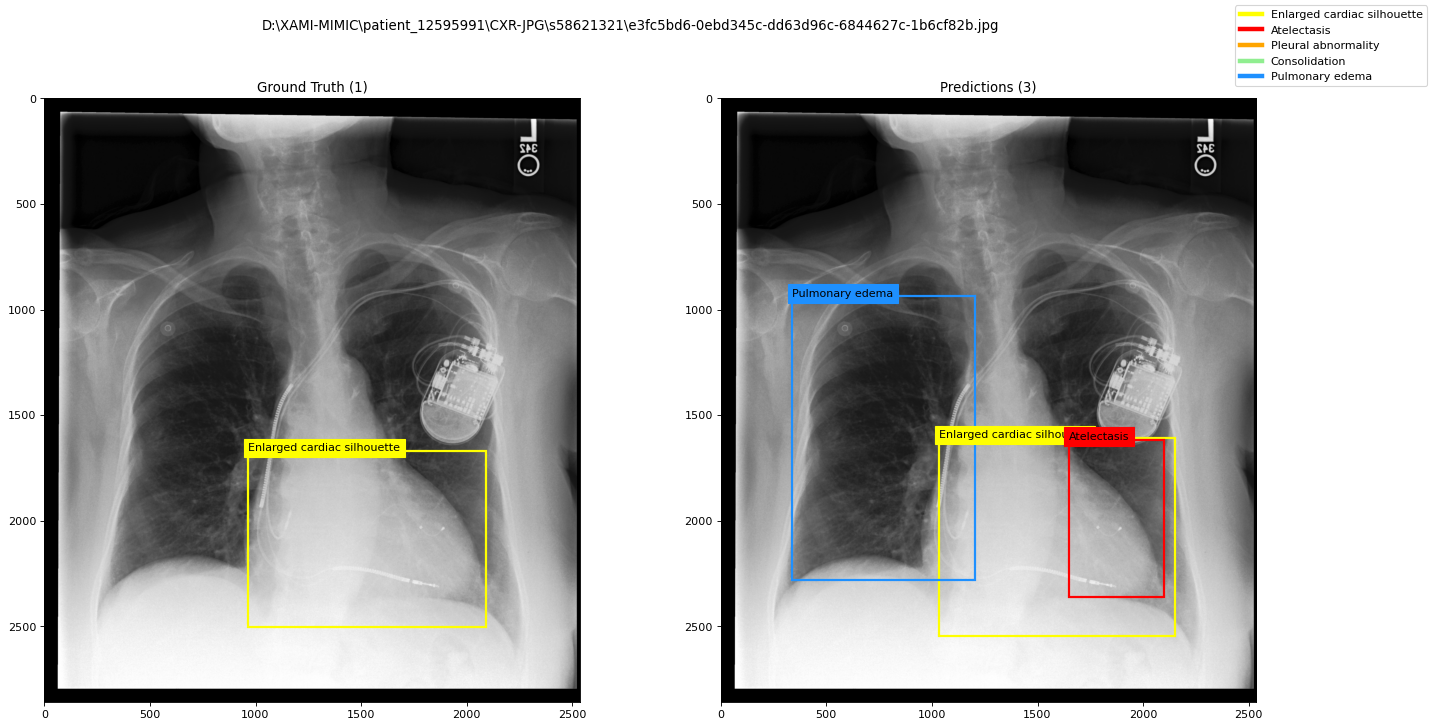

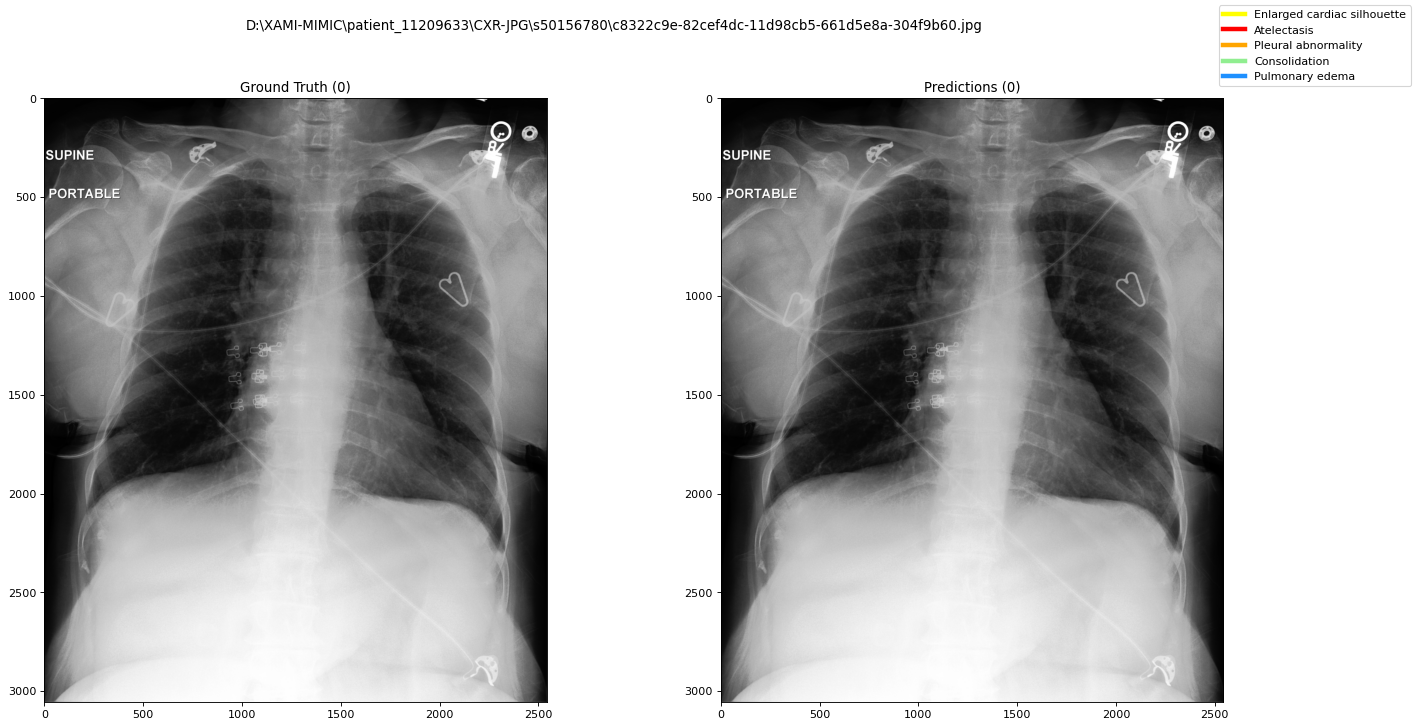

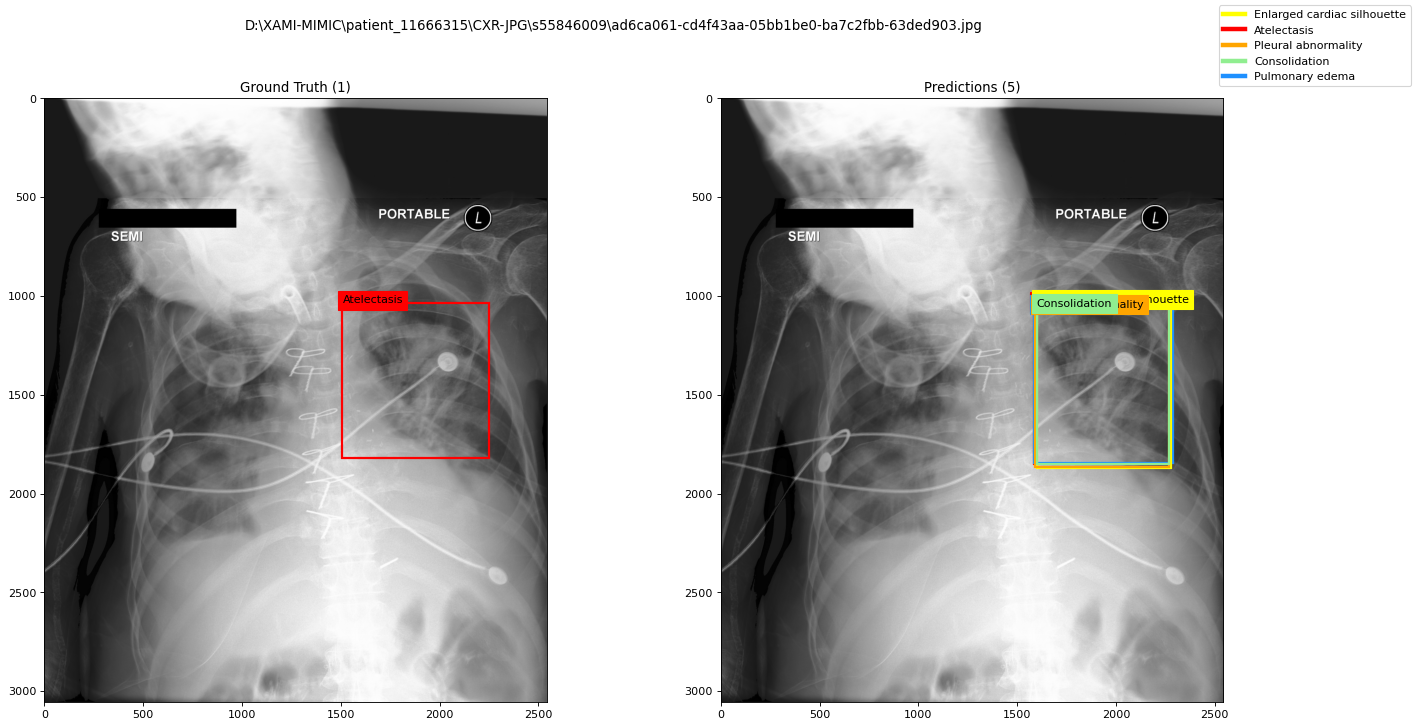

In [ ]:
for i in [250, 99, 199]:
    plot_result(
        model=model,
        dataset=detect_eval_dataset,
        device=device,
        idx= i,
        legend_elements= legend_elements,
        disease_cmap =disease_cmap,
        seg=False,
        seg_thres=0.5,
    )

In [ ]:
training_record = OrderedDict({
    "train_data": [ get_train_data(loger) for loger in train_logers],
    "val_evaluators" : val_evaluators,
    "test_evaluator": test_evaluator,
})

In [ ]:
clinial_cond = "With" if train_dataset.with_clinical else "Without"
current_time_string = datetime.now().strftime("%m-%d-%Y %H-%M-%S")
final_model_path =  f"epoch{epoch}_{clinial_cond}Clincal_{current_time_string}".replace(":", "_").replace(".", "_")

In [ ]:
torch.save(model.state_dict(), os.path.join(
    os.path.join('trained_models', final_model_path)
))

print(f"Model has been saved: {final_model_path}")

Model has been saved: epoch99_WithClincal_03-11-2022 17-34-14


In [ ]:
# epoch99_WithoutClincal_03-11-2022 09-05-17 
# epoch99_WithClincal_03-11-2022 17-34-14


In [ ]:
with open(
    os.path.join("training_records", f"{final_model_path}.pkl"), "wb",
) as training_record_f:
    pickle.dump(training_record, training_record_f)